<a href="https://www.kaggle.com/code/ubaydulloasatullaev/crowddetection1?scriptVersionId=159149878" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
!git clone https://github.com/ZhengPeng7/CSRNet-Keras.git

Cloning into 'CSRNet-Keras'...
remote: Enumerating objects: 116, done.
remote: Total 116 (delta 0), reused 0 (delta 0), pack-reused 116
Receiving objects: 100% (116/116), 7.83 MiB | 14.27 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [4]:
ls

CSRNet-Keras/


In [5]:
cd CSRNet-Keras

/kaggle/working/CSRNet-Keras


In [6]:
ls

CSRNet.py                utils_callback.py
README.md                utils_gen.py
data/                    utils_imgproc.py
generate_datasets.ipynb  utils_loss.py
main.ipynb               weights_A_MSE_bestMAE67.984_Thu-May-23/
materials/               weights_B_MSE_bestMAE8.31_Sun-May-19/
models/


## data generation

In [7]:
import os
import cv2
import glob
import h5py
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm
from utils_gen import gen_density_map_gaussian
import matplotlib.pyplot as plt
%matplotlib inline

root = '/kaggle/input/shanghaitech/ShanghaiTech'
part_A_train = os.path.join(root, 'part_A/train_data', 'images')
part_A_test = os.path.join(root, 'part_A/test_data', 'images')
part_B_train = os.path.join(root, 'part_B/train_data', 'images')
part_B_test = os.path.join(root, 'part_B/test_data', 'images')
path_sets_A = [part_A_train, part_A_test]
path_sets_B = [part_B_train, part_B_test]
img_paths_A = []
for path in path_sets_A:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_A.append(img_path)
print(len(img_paths_A))
img_paths_B = []
for path in path_sets_B:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths_B.append(img_path)
print(len(img_paths_B))

482
716


In [9]:
import os
import h5py
from tqdm.notebook import tqdm  # Use tqdm.notebook in Kaggle for progress bars

# Specify the output directory path in the working directory
output_directory_path = '/kaggle/working/train_data/ground/'

# Create directories if they don't exist
os.makedirs(output_directory_path, exist_ok=True)

# Iterate through the dataset
for dataset in ['A']:
    img_paths = eval('img_paths_' + dataset)
    
    # Iterate through the image paths
    for img_path in tqdm(img_paths):
        img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
        img = cv2.imread(img_path)
        sigma = 4 if 'part_A' in img_path else 15
        k = np.zeros((img.shape[0], img.shape[1]))
        gt = pts['image_info'][0,0][0,0][0]
        
        for i in range(len(gt)):
            if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
                k[int(gt[i][1]), int(gt[i][0])] = 1
                
        DM = gen_density_map_gaussian(k, gt, sigma=sigma)

        # Modify the file path to save in the working directory
        file_path = os.path.join(output_directory_path, os.path.basename(img_path).replace('.jpg', '.h5'))
        with  h5py.File(file_path, 'w') as hf:
            hf['density'] = DM
            
# script reads images, process ground truth information, generates density maps, saves them in hdf5 format

  0%|          | 0/482 [00:00<?, ?it/s]

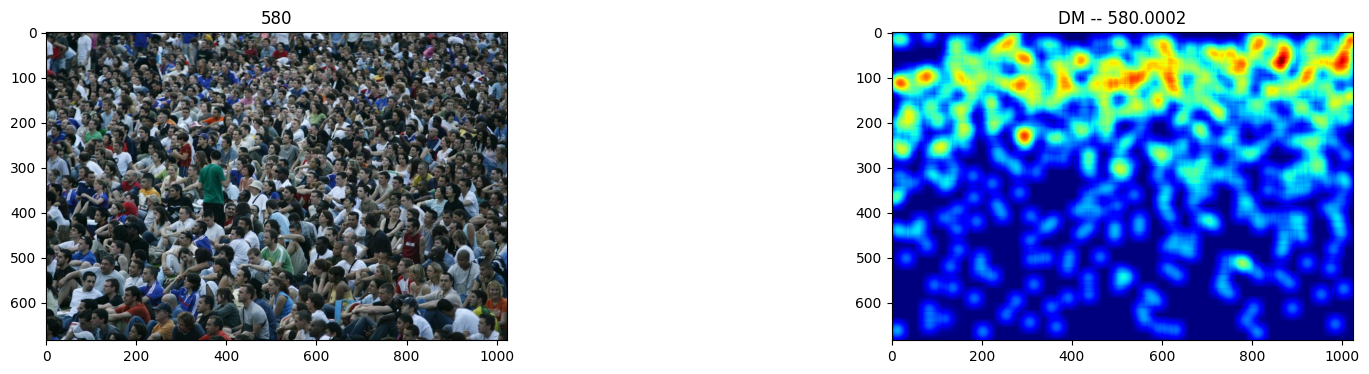

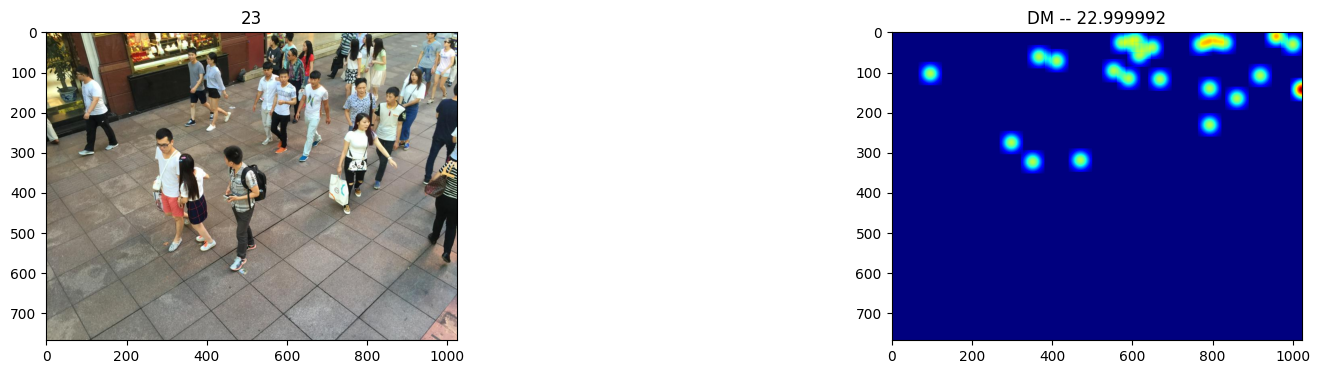

In [20]:
# Show a sample
img_paths = ['/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images/IMG_196.jpg',
             '/kaggle/input/shanghaitech/ShanghaiTech/part_B/test_data/images/IMG_1.jpg']
for img_path in img_paths:
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)
    
    sigma = 4  if 'part_A' in img_path else 15
    k = np.zeros((img.shape[0], img.shape[1]))
    gt = pts["image_info"][0, 0][0, 0][0]
    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    DM = gen_density_map_gaussian(k, gt, sigma=sigma)
    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(img_ori)
    ax0.set_title(str(gt.shape[0]))
    ax1.imshow(np.squeeze(DM), cmap=plt.cm.jet)
    ax1.set_title('DM -- '+str(np.sum(DM)))
    plt.show()
    
# this snippet provides visual representation of an image along with its ground truth points and corresponding density map


## Train/Test

In [19]:
!python --version

Python 3.10.12


In [24]:
ls

CSRNet.py                models/
README.md                utils_callback.py
__pycache__/             utils_gen.py
data/                    utils_imgproc.py
generate_datasets.ipynb  utils_loss.py
main.ipynb               weights_A_MSE_bestMAE67.984_Thu-May-23/
materials/               weights_B_MSE_bestMAE8.31_Sun-May-19/


In [38]:
# Import the necessary modules
import os
import cv2
import time
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json
from utils_gen import gen_paths_img_dm, gen_var_from_paths
from utils_imgproc import norm_by_imagenet
%matplotlib inline
plt.ioff()

# Settings
net = 'CSRNet'
dataset = "A"

# Define the root directory
root = '/kaggle/input/shanghaitech/ShanghaiTech'

# Specify the paths to the train and test images directories
train_img_directory = os.path.join(root, 'part_A/train_data/images')
test_img_directory = os.path.join(root, 'part_A/test_data/images')

# Generate train and test image paths directly
train_img_paths = [os.path.join(train_img_directory, img_name) for img_name in os.listdir(train_img_directory) if img_name.endswith(('.png', '.jpg', '.jpeg'))]
test_img_paths = [os.path.join(test_img_directory, img_name) for img_name in os.listdir(test_img_directory) if img_name.endswith(('.png', '.jpg', '.jpeg'))]

# Verify image paths for train set
for img_path in train_img_paths:
    if not os.path.exists(img_path):
        print(f"Train Image not found: {img_path}")

# Verify image paths for test set
for img_path in test_img_paths:
    if not os.path.exists(img_path):
        print(f"Test Image not found: {img_path}")

In [39]:
print(train_img_directory)
print(test_img_directory)

/kaggle/input/shanghaitech/ShanghaiTech/part_A/train_data/images
/kaggle/input/shanghaitech/ShanghaiTech/part_A/test_data/images


In [44]:
# Generate raw images (normalized by imagenet rgb) and density maps
train_x_paths, train_y_paths = train_img_paths[:], train_img_paths[:]
test_x_paths, test_y_paths = test_img_paths[:], test_img_paths[:]

In [47]:
from utils_gen import gen_paths_img_dm, gen_var_from_paths

# Generate train data
train_x = gen_var_from_paths(train_x_paths, unit_len=None)
train_y = gen_var_from_paths(train_y_paths, stride=8, unit_len=None)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (300,) + inhomogeneous part.

In [48]:
def gen_var_from_paths(paths, stride=None, unit_len=None):
    vars = []
    for ph in paths:
        raw = cv2.cvtColor(cv2.imread(ph), cv2.COLOR_BGR2RGB).astype(np.float32)
        if unit_len:
            raw = fix_singular_shape(raw, unit_len=unit_len)
        if stride:
            raw = cv2.resize(raw, (0, 0), fx=1 / stride, fy=1 / stride, interpolation=cv2.INTER_CUBIC)
        vars.append(raw)
    return np.stack(vars, axis=0)

# Generate train data
train_x = gen_var_from_paths(train_x_paths, unit_len=None)
train_y = gen_var_from_paths(train_y_paths, stride=8, unit_len=None)


ValueError: all input arrays must have the same shape